In [11]:
import pymc3 as pm
import requests
import zipfile
import math
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# まずはデータの処理

In [3]:
# データ
dat = pd.read_csv('hlm_data.csv', encoding="Shift-JIS")
dat.head(3)

,順列,個人成績,集団成績,条件,誤答率,平均反応時間
0,1,9,10,1,0.0,517.8
1,1,8,10,1,0.0,591.1
2,1,10,10,1,0.1,484.0


In [4]:
dat.columns = ["P", "ind_per","group_per", "cond", "error", "RT"]
dat.head(3)

,P,ind_per,group_per,cond,error,RT
0,1,9,10,1,0.0,517.8
1,1,8,10,1,0.0,591.1
2,1,10,10,1,0.1,484.0


In [5]:
# 階層データを中心化
# 集団に準じる個人データ
P_average = []
for i in range(0,6):
    P_sum = []
    for j in range(0,4):
        P_sum.append(dat.iloc[i*4+j, 4])
    P_average.append(np.mean(P_sum))

error_g=[]
for i in range(0,6):
    ave = P_average[i]
    for j in range(0,4):
        error_g.append(dat.iloc[i*4+j, 4] - ave)
dat["error_g"] = error_g

# 集団に準じる集団データ
mean = np.mean(dat["group_per"])
for i in range(0, len(dat)):
    dat.iloc[i,2] = dat.iloc[i,2] - mean    

dat.head(3)

,P,ind_per,group_per,cond,error,RT,error_g
0,1,9,3.666667,1,0.0,517.8,-0.0375
1,1,8,3.666667,1,0.0,591.1,-0.0375
2,1,10,3.666667,1,0.1,484.0,0.0625


# MCMCするよ

In [21]:
# error_gを階層データとして扱う
# ind_perをgroup_perとerror_gが予測するか
import numpy as np
import scipy.stats as st
import scipy.linalg as la
import pymc3 as pm
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import sys

FontPath = "C:\\Windows\\Fonts\\meiryo.ttc"
jpfont = FontProperties(fname = FontPath)

n = 24
X = np.stack((np.ones(n), dat["group_per"], dat["error_g"]), axis = 1)
# 回帰モデルの係数と誤差項の分散の事後分布（？）の設定
k = 3 # 説明変数の量
b0 = np.zeros(k)
A0 = 0.2 * np.eye(k)
nu0 = 5.0 # とりあえず
lam0 = 7.0 # とりあえず
sd0 = np.sqrt(np.diag(la.inv(A0)))
multiple_regression = pm.Model()
with multiple_regression:
    sigma2 = pm.InverseGamma("sigma2", alpha = 0.5*nu0, beta = 0.5*lam0) # 切片の事前分布（逆ガンマ）
    b = pm.MvNormal("b", mu = b0, tau = A0, shape = k) # 説明変数の事前分布（正規分布）
    
    #sp = pm.Normal("sp", mu = np.mean(dat["error_g"]), sd = np.std(dat["error_g"])) # ランダム効果の事前分布（一様分布）
    hd = pm.Normal("hd", mu = np.mean(dat["error_g"]), sd = np.std(dat["error_g"]), shape = len(dat.P.unique())) # ランダム効果（正規分布）
    
    y_hat = pm.math.dot(X, b) # 固定効果
    likelihood = pm.Normal("y", mu = y_hat , sd = pm.math.sqrt(sigma2), observed = dat["ind_per"])

In [22]:
# 事後分布からのサンプリング
n_draws = 5000
n_chains = 4
n_tune = 1000
with multiple_regression:
    trace = pm.sample(draws = n_draws, chains = n_chains, tune = n_tune, random_seed = 123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [hd, b, sigma2]
Sampling 4 chains: 100%|█████████████████████████████████████████████████████| 24000/24000 [00:32<00:00, 735.59draws/s]


In [23]:
print(pm.summary(trace))

            mean        sd  mc_error   hpd_2.5  hpd_97.5         n_eff  \
b__0    5.657032  0.213425  0.001548  5.226186  6.070385  21402.876755   
b__1    1.084794  0.078523  0.000554  0.930629  1.237822  20179.335162   
b__2    0.341328  2.149276  0.014427 -3.819945  4.557139  20908.560862   
hd__0  -0.000129  0.024628  0.000156 -0.049359  0.047335  20963.446810   
hd__1   0.000015  0.024870  0.000147 -0.048384  0.049083  22590.685197   
hd__2  -0.000117  0.024754  0.000148 -0.049977  0.047076  23756.694565   
hd__3  -0.000046  0.024747  0.000158 -0.049439  0.048116  21864.118614   
hd__4  -0.000100  0.024710  0.000135 -0.047212  0.048967  23914.164612   
hd__5  -0.000249  0.024529  0.000165 -0.048163  0.046828  23223.950781   
sigma2  1.095945  0.323772  0.002438  0.563237  1.736809  16551.270051   

            Rhat  
b__0    0.999946  
b__1    0.999949  
b__2    0.999985  
hd__0   0.999967  
hd__1   1.000111  
hd__2   0.999902  
hd__3   1.000098  
hd__4   0.999972  
hd__5   1.0000

C:\Users\mimus\Anaconda3\lib\site-packages\pymc3\stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


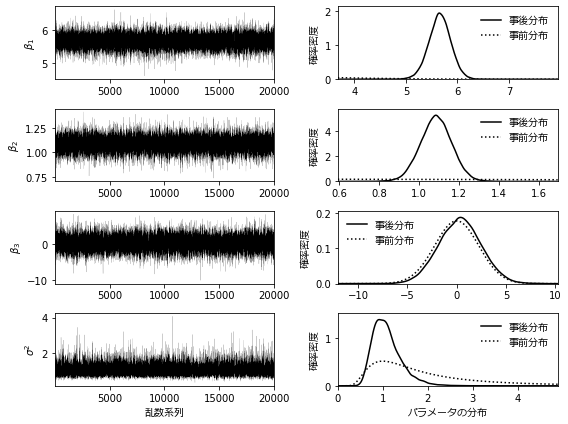

In [24]:
# 事後分布のグラフの作成
fig, ax = plt.subplots(k+1, 2, num=1, figsize = (8, 1.5*(k+1)), facecolor = "w")
for index in range(k+1):
    if index < k:
        mc_trace = trace["b"][:, index]
        x_min = mc_trace.min() - 0.2*np.abs(mc_trace.min())
        x_max = mc_trace.max() + 0.2*np.abs(mc_trace.max())
        x = np.linspace(x_min, x_max, 250)
        prior = st.norm.pdf(x, loc = b0[index], scale = sd0[index])
        y_label = "$\\beta_{:<d}$".format(index+1)
    else:
        mc_trace = trace["sigma2"]
        x_min = 0.0
        x_max = mc_trace.max() + 0.2*np.abs(mc_trace.max())
        x = np.linspace(x_min, x_max, 250)
        prior = st.invgamma.pdf(x, 0.5*nu0, scale=0.5*lam0)
        y_label = "$\\sigma^2$"
        ax[index, 0].set_xlabel("乱数系列", fontproperties = jpfont)
        ax[index, 1].set_xlabel("パラメータの分布", fontproperties = jpfont)
    ax[index, 0].plot(mc_trace, "k-", linewidth = 0.1)
    ax[index, 0].set_xlim(1, n_draws*n_chains)
    ax[index, 0].set_ylabel(y_label, fontproperties = jpfont)
    posterior = st.gaussian_kde(mc_trace).evaluate(x)
    ax[index, 1].plot(x, posterior, "k-", label = "事後分布")
    ax[index, 1].plot(x, prior, "k:", label = "事前分布")
    ax[index, 1].set_xlim(x_min, x_max)
    ax[index, 1].set_ylim(0, 1.1*posterior.max())
    ax[index, 1].set_ylabel("確率密度", fontproperties=jpfont)
    ax[index, 1].legend(loc="best", frameon=False, prop = jpfont)
plt.tight_layout()
plt.show()

# おまけ

In [25]:
# 階層データとか何も考えずに重回帰モデル
# ind_perをgroup_perとerror_gが予測するか
import numpy as np
import scipy.stats as st
import scipy.linalg as la
import pymc3 as pm
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import sys

FontPath = "C:\\Windows\\Fonts\\meiryo.ttc"
jpfont = FontProperties(fname = FontPath)

n = 24
X = np.stack((np.ones(n), dat["group_per"], dat["error_g"]), axis = 1)
# 回帰モデルの係数と誤差項の分散の事後分布（？）の設定
k = 3 # 説明変数の量
b0 = np.zeros(k)
A0 = 0.2 * np.eye(k)
nu0 = 5.0 # とりあえず
lam0 = 7.0 # とりあえず
sd0 = np.sqrt(np.diag(la.inv(A0)))
multiple_regression = pm.Model()
with multiple_regression:
    sigma2 = pm.InverseGamma("sigma2", alpha = 0.5*nu0, beta = 0.5*lam0)
    b = pm.MvNormal("b", mu = b0, tau = A0, shape = k)
    y_hat = pm.math.dot(X, b)
    likelihood = pm.Normal("y", mu = y_hat, sd = pm.math.sqrt(sigma2), observed = dat["ind_per"])
    
# 事後分布からのサンプリング
n_draws = 5000
n_chains = 4
n_tune = 1000
with multiple_regression:
    trace = pm.sample(draws = n_draws, chains = n_chains, tune = n_tune, random_seed = 123)

print(pm.summary(trace))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, sigma2]
Sampling 4 chains: 100%|████████████████████████████████████████████████████| 24000/24000 [00:18<00:00, 1287.92draws/s]

            mean        sd  mc_error   hpd_2.5  hpd_97.5         n_eff  \
b__0    5.655997  0.215305  0.001334  5.217034  6.070169  25151.885667   
b__1    1.085739  0.079560  0.000498  0.920818  1.235344  25014.778442   
b__2    0.332390  2.176256  0.012215 -4.025948  4.510069  26307.583648   
sigma2  1.099155  0.323729  0.002277  0.566012  1.735980  18491.922796   

            Rhat  
b__0    0.999940  
b__1    0.999966  
b__2    0.999979  
sigma2  0.999909  



C:\Users\mimus\Anaconda3\lib\site-packages\pymc3\stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


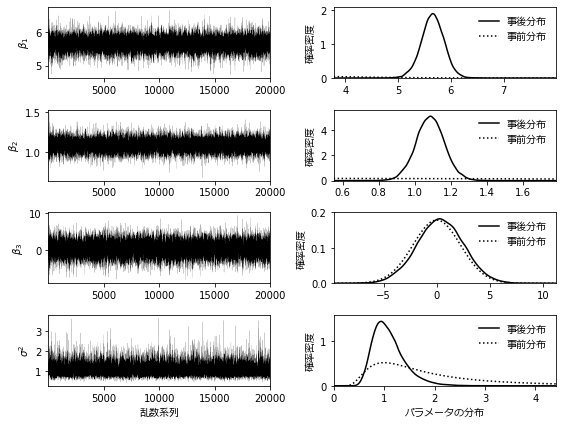

In [14]:
# 事後分布のグラフの作成
fig, ax = plt.subplots(k+1, 2, num=1, figsize = (8, 1.5*(k+1)), facecolor = "w")
for index in range(k+1):
    if index < k:
        mc_trace = trace["b"][:, index]
        x_min = mc_trace.min() - 0.2*np.abs(mc_trace.min())
        x_max = mc_trace.max() + 0.2*np.abs(mc_trace.max())
        x = np.linspace(x_min, x_max, 250)
        prior = st.norm.pdf(x, loc = b0[index], scale = sd0[index])
        y_label = "$\\beta_{:<d}$".format(index+1)
    else:
        mc_trace = trace["sigma2"]
        x_min = 0.0
        x_max = mc_trace.max() + 0.2*np.abs(mc_trace.max())
        x = np.linspace(x_min, x_max, 250)
        prior = st.invgamma.pdf(x, 0.5*nu0, scale=0.5*lam0)
        y_label = "$\\sigma^2$"
        ax[index, 0].set_xlabel("乱数系列", fontproperties = jpfont)
        ax[index, 1].set_xlabel("パラメータの分布", fontproperties = jpfont)
    ax[index, 0].plot(mc_trace, "k-", linewidth = 0.1)
    ax[index, 0].set_xlim(1, n_draws*n_chains)
    ax[index, 0].set_ylabel(y_label, fontproperties = jpfont)
    posterior = st.gaussian_kde(mc_trace).evaluate(x)
    ax[index, 1].plot(x, posterior, "k-", label = "事後分布")
    ax[index, 1].plot(x, prior, "k:", label = "事前分布")
    ax[index, 1].set_xlim(x_min, x_max)
    ax[index, 1].set_ylim(0, 1.1*posterior.max())
    ax[index, 1].set_ylabel("確率密度", fontproperties=jpfont)
    ax[index, 1].legend(loc="best", frameon=False, prop = jpfont)
plt.tight_layout()
plt.show()